In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


This notebook offers an interpretation of the results of the logistic regression analysis.

In [3]:
col_order = ['group_metrics', 'group_metric_offset', 'weight', 'retain_impact']
logreg_summary_df = pd.read_csv('../output/socialnet7_dataset2_logreg_summary.csv')
logreg_summary_df = logreg_summary_df[col_order]

`weight` - a positive weight indicates that a metric (or group) is associated with increased engagement.

`retain_impact` - represents how much difference in the retention probability it would make to be one standard deviation above average for this metric (or group), assuming a customer was average in all other aspects.

If the retention impact for a metric is 2%, a customer who is one standard deviation above average on that metric and average in all the other metrics has a forecast retention probability 2% higher than the average retention probability.

The results for the model offset are included. The `weight` for the offset is not a weight, but just the amount of the offset. The `retain_impact` of the offset is the retention probability forecast for a perfectly average customer (i.e. one with zero scores in all metrics).


In [4]:
pd.set_option('display.max_colwidth', None)
logreg_summary_df.sort_values(by=['retain_impact'], ascending=False)

,group_metrics,group_metric_offset,weight,retain_impact
9,(baseline),offset,3.534486,0.971653
2,message_per_month|reply_per_month,metric_group_3,0.677812,0.013751
0,adview_per_month|like_per_month|newfriend_per_month|post_per_message|post_per_month,metric_group_1,0.610598,0.012752
7,newfriend_pcnt_chng,newfriend_pcnt_chng,0.175516,0.004454
6,dislike_pcnt,dislike_pcnt,-0.002006,-0.000055
5,reply_per_message,reply_per_message,-0.026286,-0.000733
1,unfriend_per_month|unfriend_per_newfriend,metric_group_2,-0.104359,-0.003020
3,dislike_per_month,dislike_per_month,-0.112772,-0.003277
8,days_since_newfriend,days_since_newfriend,-0.147217,-0.004349
4,adview_per_post,adview_per_post,-0.318860,-0.010235


Plotting the impacts on retention probability as a bar chart makes them easier to interpret. We also create a set of labels for groups to explain the theme of the metric:

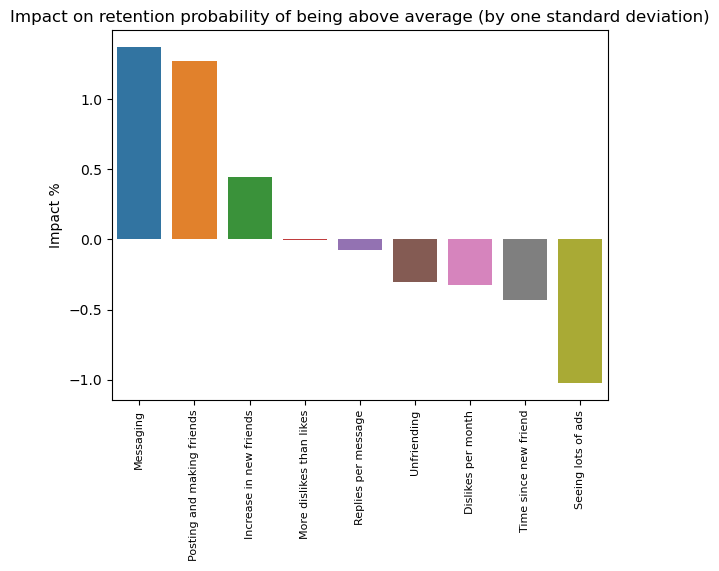

In [5]:
label_dict = {
    'metric_group_1': 'Posting and making friends',
    'metric_group_2': 'Unfriending',
    'metric_group_3': 'Messaging',
    'newfriend_pcnt_chng': 'Increase in new friends',
    'dislike_pcnt': 'More dislikes than likes',
    'reply_per_message': 'Replies per message',
    'adview_per_post': 'Seeing lots of ads',
    'days_since_newfriend': 'Time since new friend',
    'dislike_per_month': 'Dislikes per month'
}

rows_to_drop = logreg_summary_df[logreg_summary_df['group_metric_offset'] == 'offset']
sorted_df = (
    logreg_summary_df.drop(rows_to_drop.index)
    .sort_values(by='retain_impact', ascending=False)
    .assign(retain_impact=lambda x: x['retain_impact'] * 100) # convert to percentage
)
# Add a column of labels describing the theme of the metric
sorted_df['metric_theme'] = sorted_df['group_metric_offset'].map(label_dict)

sns.barplot(data=sorted_df, x='metric_theme', y='retain_impact')
plt.title('Impact on retention probability of being above average (by one standard deviation)')
plt.xlabel('')
plt.ylabel('Impact %')
plt.xticks(rotation=90, fontsize=8)
plt.show()

These results would suggest that _being above average_ in messaging activity, posting and continuing to make friends have the biggest positive impact on retention, while _being above average_ seeing lots of ads, going long periods between making new friends and disliking content have the biggest negative impact on retention.

Interestingly, the ratio of likes to dislikes has a negligible impact on churn/retention.

It's also important to note that:
- Being below average will have an approximately equal and opposite effect.
- If a customer is multiple standard deviations above average, there are diminishing returns, meaning that each additional standard deviation above average has less impact on the churn or retention probability.
- The same diminishing returns goes for being above average in multiple respects:
the combined churn probability reduction will be lower than the sum of the quoted retention probability impacts.

Before going further, we should check that the model is calibrated. A good check of model calibration is to compare the historical churn probabilities predicted by the model to the summary statistics of the dataset.

In [14]:
predictions_df = pd.read_csv('../output/socialnet7_dataset2_predictions.csv')

# Show the mean churn and retention probabilities predicted by the model
predictions_df[['churn_prob', 'retain_prob']].mean()

churn_prob     0.047886
retain_prob    0.952114
dtype: float64

In [13]:
summary_stats_df = pd.read_csv('../../output/socialnet7_dataset2_summarystats.csv')

# Grab the summary stat for just churn
summary_stats_df.loc[summary_stats_df.iloc[:, 0] == 'is_churn']

,Unnamed: 0,count,nonzero,mean,std,skew,min,1pct,25pct,50pct,75pct,99pct,max
0,is_churn,25143,0.047846,0.047846,0.213445,4.237056,0,0,0.0,0.0,0.0,1.0,1.0


We can see that the mean churn probability predicted by the model is very close to the churn rate of the sample dataset.